# Генератор данных для задач классификации

В этом блокноте рассматривается задача о классификации набора векторов. Под каждым вектором мы понимаем строго фиксированную по порядку совокупность признаков, числового типа. Каждая такая совокупность характеризует состояние исследуемой системы в определенный момент времени измерений. Предполагаемая система может находиться в трех состояниях. Поэтому исследуемый набор векторов строго разделяется на три класса. В качестве примера такой системы рассмотрим процесс фиксации электро-энцефалограммы (ЭЭГ) мозга. При фиксации ЭЭГ эксперт отмечает характерные временные участки, на которых электрический сигнал ЭЭГ имеет определенную частоту колебаний, отражающих ритмическую активность внутренних процессов в мозге. (Такие ритмы еще принято называть осцилляторными структурами.) Эксперт в зависимости от исследуемой проблемы может по-разному объединять эти активности в разные классы, отмечая те или иные колебания на записи ЭЭГ. На каждой такой отмеченной записи может присутствовать от одной до нескольких осцилляторных структур и фоновых шумов.

Установлены четыре наиболее доминантные ритмические активности: дельта, тетта, альфа и бетта.
Мы будем рассматривать три класса состояний мозга на ЭЭГ по соответствующим ритмам:<br>
1) фоновая слабовыраженная активность: суммарынй набор ритмов дельта, тетта, альфа и бетта<br>
2) сильно выраженная бетта-активность (высокие частоты): бетта ритм<br>
3) сильно выраженная альфа-активность (средние частоты): альфа ритм<br>

Каждый отдельно взятый ритм может быть описан колебательным процессом (например семейством функций sin/cos) c центральной частотой и дополнительными суб-гармониками. Под каждый ритм принято отводить диапазон частот. Таблица диапазонов частот ЭЭГ хорошо известна (на четыре указанных ритма выделяется спектральный диапазон от 0 до 30 Гц). Мы рассматриваем одноканальную запись ЭЭГ, на которой эксперт размечает все три состояния (1,2,3) как три вышеописанных класса активностей.<br>

Одноканальный ЭЭГ-сигнал в виде временного ряда мы преобразуем в набор векторов на основе преобразования Фурье со скользящим временным окном. Значения самого сигнала для нас не представляют особой ценности, а вот мгновенное состояние спектра как результат Фурье преобразования в каждой временной точке сигнала - это и будет информация для комплектации набора векторов. Эксперт при разметке определил три класса, следовательно мы анализируем 3 разных набора дискретизованных спектров. Дискретизованный спектр мы соотносим с вектором при решении задачи классификации состояний классам 1, 2 и 3. Будем рассматривать спектр от 1 до 50 Гц с дискретизацией 1 Гц, поэтому вектор будет иметь 50 координат. Ниже приведен код, который эмулирует опыт с ЭЭГ и дает соответствующую разбивку векторов по классам 1, 2 и 3.

In [1]:
import numpy as np
import math
import random
import pandas as pd



# additional functions:---------------------------------------------
def rand_int_array(low,high,size):
    return np.array(np.random.randint(low=low,high=high,size=size,dtype=int));

def rand_flt_array (low,high,size):
    return (high - low) * np.random.sample(size) + low


# The main settings store class:------------------------------------
class SettingsStore:
    
    def __init__ (self,delta_t,q_sample,t_min,t_max):
        self.delta_t = delta_t;
        self.q_sample = q_sample;
        self.t_min = t_min;
        self.t_max = t_max;
        self.relation_tau_pointers = rand_int_array(low=self.t_min, high=self.t_max, size=self.q_sample);
        self.q_points = self.relation_tau_pointers.sum();
        self.tau_pointers = None;
    
   
    def init_tau_pointers(self):
        self.tau_pointers = np.array([],dtype=int);
        
        sum = 0;
        for relation_tau_pointer in self.relation_tau_pointers:
            sum += relation_tau_pointer;
            self.tau_pointers = np.append(self.tau_pointers,int(sum));
            
        assert(sum==self.q_points);
        print ("  --> Settings store post construct completed {}".format(self));
        return self;
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);

    
# The class of EEG frequencies set definition:----------------------
class EegFreqs:
    
    def __init__ (self,freq_size):
        self.__delta_freqs = rand_flt_array(low=1,high=5,size=freq_size);
        self.__theta_freqs = rand_flt_array(low=4,high=8,size=freq_size);
        self.__alpha_freqs = rand_flt_array(low=7,high=15,size=freq_size);
        self.__betta_freqs = rand_flt_array(low=14,high=31,size=freq_size);
       
    def delta(self):
        return np.random.choice(self.__delta_freqs);
    def theta(self):
        return np.random.choice(self.__theta_freqs);
    def alpha(self):
        return np.random.choice(self.__alpha_freqs);
    def betta(self):
        return np.random.choice(self.__betta_freqs);
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);

    
# The class of EEG sin wave generators:-----------------------------
class EegGenerators:
    
    def __init__(self,eeg_freqs,settings,phase_scale,noise_ratio):
        self.__eeg_freqs = eeg_freqs;
        self.__settings = settings;
        
        self.__generator_cnt = 0;
        self.__phase_scale = phase_scale;
        self.__phase = 0.0;
        self.__noise_ratio = noise_ratio;
        self.__delta = eeg_freqs.delta();
        self.__theta = eeg_freqs.theta();
        self.__alpha = eeg_freqs.alpha();
        self.__betta = eeg_freqs.betta();
            
    def generate_background(self,i):
        xtr = self.__delta_signal(i);
        xtr += self.__theta_signal(i);
        xtr += self.__alpha_signal(i);
        xtr += self.__betta_signal(i);
        xtr += self.__noise_signal()
        return xtr;
    
    def generate_alpha(self,i):
        return 4.0*self.__alpha_signal(i)+self.__noise_signal();
    
    def generate_betta(self,i):
        return 4.0*self.__betta_signal(i)+self.__noise_signal();
        
    def __delta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__delta,i);
    
    def __theta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__theta,i);
    
    def __alpha_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__alpha,i);
    
    def __betta_signal(self,i):
        self.__control_generating();
        return self.__sin(self.__betta,i);
            
    def __sin (self, freq, index):
        return math.sin(2*math.pi*self.__settings.delta_t*freq*index+self.__phase);
    
    def __noise_signal(self):
        return random.gauss(mu=0, sigma=self.__noise_ratio)
    
    def __reset_phase (self):
        self.__phase = random.random()*math.pi;
        self.__delta = self.__eeg_freqs.delta();
        self.__theta = self.__eeg_freqs.theta();
        self.__alpha = self.__eeg_freqs.alpha();
        self.__betta = self.__eeg_freqs.betta();
        return self;
    
    def __control_generating (self):
        if self.__generator_cnt>=self.__phase_scale:
            self.__generator_cnt=0;
            self.__reset_phase();
        self.__generator_cnt+=1;
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);
        

# The main EEG waves array producer:--------------------------------
class EegWaves:
    
    def __init__ (self, settings,eeg_generators):
        self.signal=np.zeros(shape=(settings.q_points));
        self.indicator_signal=np.ndarray(shape=(2,settings.q_points),dtype=int);
        self.target_signal=np.zeros(shape=(settings.q_points));
        self.__settings = settings;
        self.__eeg_generators = eeg_generators;

    def make_waves(self):
        print("     > Launched making waves...")
        
        Qps = self.__settings.q_points;
        gen = self.__eeg_generators.generate_background;
        for i in range(0,Qps):
            self.signal[i] = gen(i);
            self.indicator_signal[0][i] = 0;
            self.indicator_signal[1][i] = 0;
            self.target_signal[i] = 1;
        print("     > Generating background was completed");
        
        Qs = self.__settings.q_sample;
        tau = self.__settings.tau_pointers;
        for j in range(0,Qs-1,2):
            select = self.__signal_selector();
            for i in range(tau[j],tau[j+1]):
                self.signal[i]=self.__generate_wave(select,i);
                self.indicator_signal[select][i]+=1;
                self.target_signal[i]+=(select+1);
        
        print("     > Made waves: {}".format(self));
        return self;
                
    def __generate_wave(self,selector,i):
        if selector==1:
            return self.__eeg_generators.generate_alpha(i);
        else:
            return self.__eeg_generators.generate_betta(i);
                
    def __signal_selector(self):
        if random.random()>0.5:
            return 1;
        else :
            return 0;
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__);
        


  --> Settings store post construct completed <class '__main__.SettingsStore'>: {'delta_t': 0.01, 'q_sample': 50, 't_min': 500, 't_max': 1000, 'relation_tau_pointers': array([860, 656, 925, 500, 899, 767, 530, 653, 721, 799, 846, 524, 912,
       553, 556, 899, 713, 742, 811, 810, 711, 961, 525, 807, 712, 881,
       891, 698, 589, 525, 726, 827, 973, 866, 822, 678, 635, 576, 603,
       933, 566, 816, 609, 638, 631, 780, 907, 614, 977, 868]), 'q_points': 37021, 'tau_pointers': array([  860,  1516,  2441,  2941,  3840,  4607,  5137,  5790,  6511,
        7310,  8156,  8680,  9592, 10145, 10701, 11600, 12313, 13055,
       13866, 14676, 15387, 16348, 16873, 17680, 18392, 19273, 20164,
       20862, 21451, 21976, 22702, 23529, 24502, 25368, 26190, 26868,
       27503, 28079, 28682, 29615, 30181, 30997, 31606, 32244, 32875,
       33655, 34562, 35176, 36153, 37021])}
  --> EEG frequencies: <class '__main__.EegFreqs'>: {'_EegFreqs__delta_freqs': array([1.54230572, 3.28984672, 4.31272151, 4

In [163]:
#--------------------------------------------------------------------------------------
# Launching:---------------------------------------------------------------------------
random.seed(19121988);
np.random.seed(19121988);

settings = SettingsStore(delta_t=0.01,q_sample=100,
                         t_min=500,t_max=1000).init_tau_pointers();

eeg_freqs = EegFreqs(freq_size=20);
print("  --> EEG frequencies: {}".format(eeg_freqs));

eeg_generators = EegGenerators(eeg_freqs=eeg_freqs,settings=settings,
                               phase_scale=2000,noise_ratio=0.65);
print("  --> EEG generators: {}".format(eeg_generators));

eeg_waves = EegWaves(settings=settings,
                     eeg_generators=eeg_generators).make_waves();

#--------------------------------------------------------------------------------------

  --> Settings store post construct completed <class '__main__.SettingsStore'>: {'delta_t': 0.01, 'q_sample': 100, 't_min': 500, 't_max': 1000, 'relation_tau_pointers': array([786, 698, 835, 888, 785, 899, 993, 536, 677, 680, 932, 604, 834,
       802, 634, 544, 788, 524, 512, 556, 550, 590, 633, 546, 760, 543,
       794, 832, 839, 647, 841, 529, 609, 549, 920, 849, 998, 981, 598,
       814, 883, 780, 862, 561, 840, 686, 897, 680, 947, 617, 906, 937,
       580, 578, 596, 934, 727, 757, 890, 576, 586, 599, 646, 603, 914,
       966, 651, 969, 642, 995, 605, 702, 738, 673, 583, 904, 876, 651,
       670, 843, 750, 523, 941, 811, 760, 632, 790, 926, 764, 693, 657,
       919, 999, 887, 971, 818, 714, 543, 685, 927]), 'q_points': 74689, 'tau_pointers': array([  786,  1484,  2319,  3207,  3992,  4891,  5884,  6420,  7097,
        7777,  8709,  9313, 10147, 10949, 11583, 12127, 12915, 13439,
       13951, 14507, 15057, 15647, 16280, 16826, 17586, 18129, 18923,
       19755, 20594, 21241, 

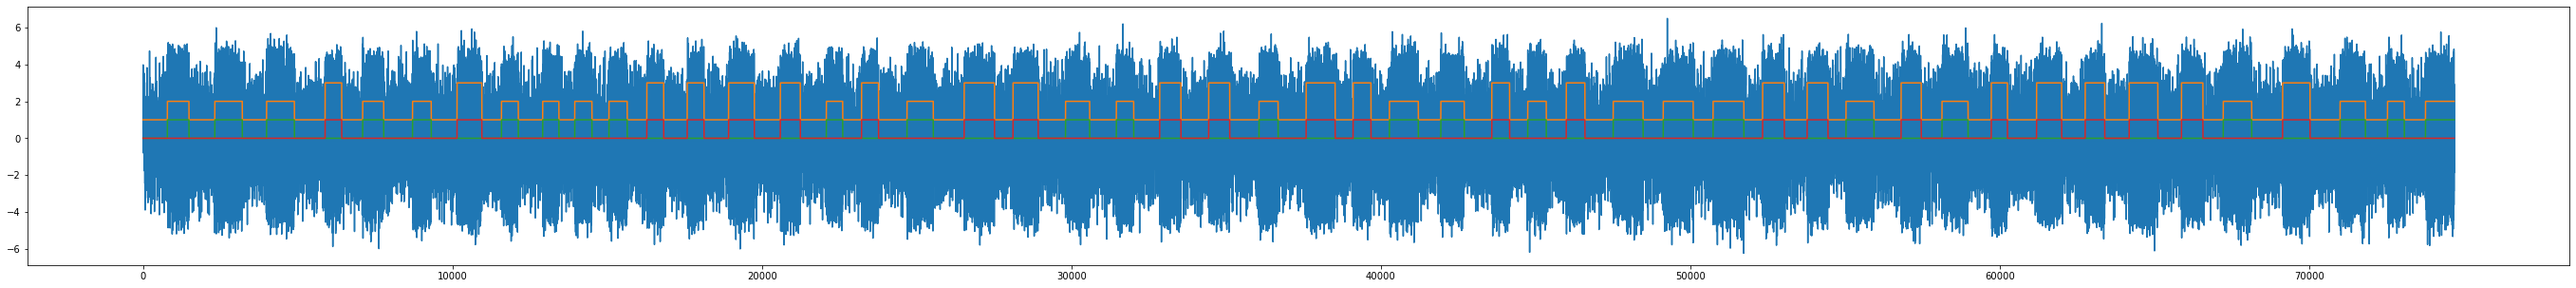

In [164]:
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 48,5

# Plotting signal:----------------------------------------------------
plt.plot(eeg_waves.signal);

# Plotting target signal:---------------------------------------------
plt.plot(eeg_waves.target_signal);

# Plotting EXPERT marker signal:--------------------------------------
plt.plot(eeg_waves.indicator_signal[0]);
plt.plot(eeg_waves.indicator_signal[1]);


The Fourier image was calculated: shape=(74689,)


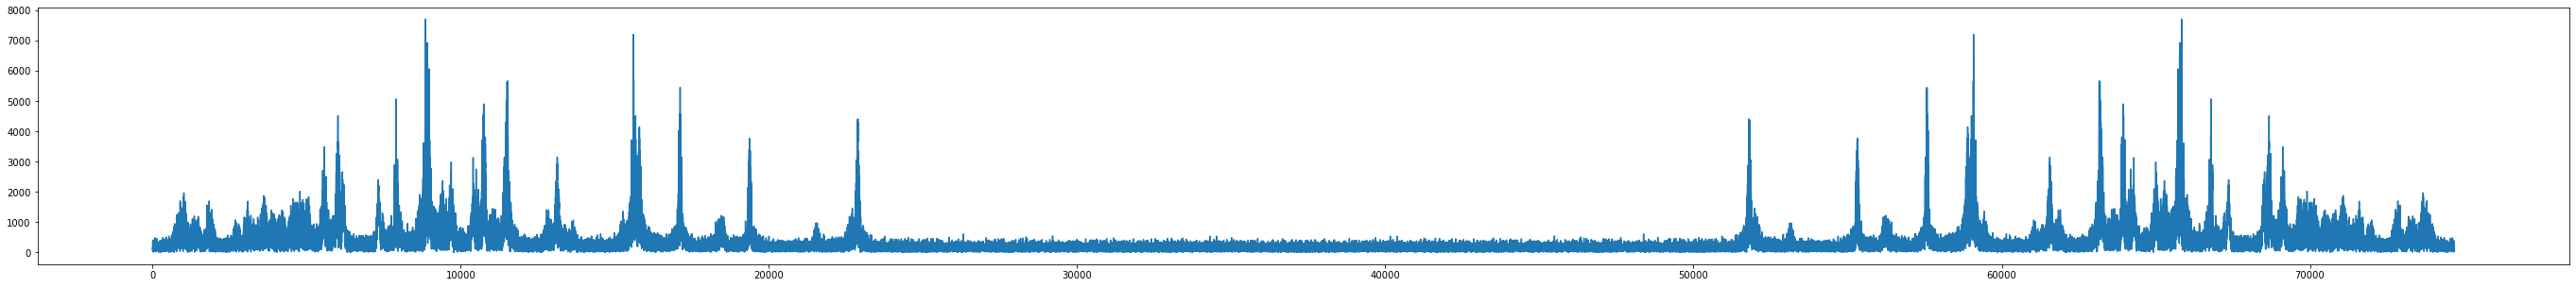

In [165]:

# Researching the EEG signal Fourier image:---------------------------

fourier_image = np.fft.fft(eeg_waves.signal);
fourier_image = np.absolute(fourier_image);
plt.plot(fourier_image);

print ("  --> The Fourier image was calculated: shape={}".format(fourier_image.shape))
# documents: https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html


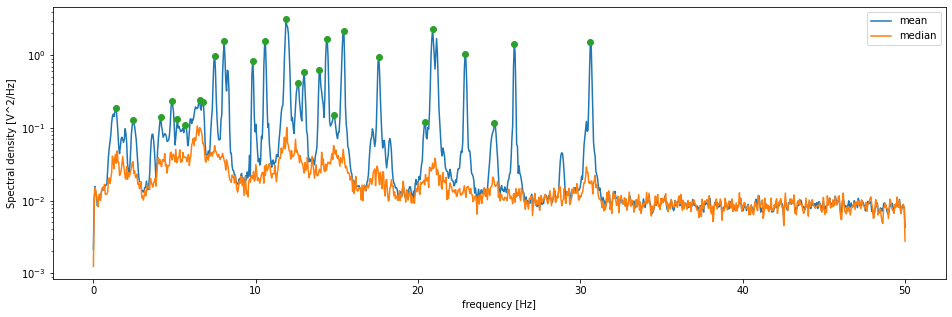

  --> The following peak frequencies were found: [ 1.3671875   2.44140625  4.15039062  4.83398438  5.17578125  5.61523438
  6.54296875  6.73828125  7.47070312  8.05664062  9.81445312 10.59570312
 11.86523438 12.59765625 12.98828125 13.91601562 14.40429688 14.84375
 15.4296875  17.578125   20.41015625 20.8984375  22.90039062 24.70703125
 25.92773438 30.61523438]
  --> Next analysis have to consider 26 frequency characteristics


In [166]:
from scipy import signal as sp
rcParams['figure.figsize'] = 16,5

# Calculating and plotting the spectral density by Welch transform:-------------------------------
window_size_welch=2048
f, Pxx_den = sp.welch(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=window_size_welch)
f_med, Pxx_den_med = sp.welch(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=window_size_welch, average='median')
plt.semilogy(f, Pxx_den, label='mean')
plt.semilogy(f_med, Pxx_den_med, label='median')
plt.xlabel('frequency [Hz]')
plt.ylabel('Spectral density [V^2/Hz]')
plt.legend()


# Finding spectral density maxima:----------------------------------------------------------------
delta_f = 1.0/(settings.delta_t*window_size_welch);
peak_indexes,peak_params = sp.find_peaks(x=Pxx_den, width=2, height=0.1)
peak_frequencies = peak_indexes*delta_f
plt.plot(peak_frequencies, peak_params['peak_heights'], "o")
plt.show()

n_spectral_features = peak_frequencies.shape[0]
print ("  --> The following peak frequencies were found: {}".format(peak_frequencies))
print ("  --> Next analysis have to consider {} frequency characteristics".format(n_spectral_features))

# ------------------------------------------------------------------------------------------------
# documents: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html#scipy.signal.find_peaks_cwt

  --> Power spectral density (51, 74690)
  --> Frequency axis (51,)
  --> Time axis (74690,)
  --> Power spectral density matrix [[0.006203   0.00933382 0.01549862 ... 0.00218326 0.00046336 0.00304374]
 [0.08718999 0.08743464 0.08903722 ... 0.00393083 0.00249452 0.00411419]
 [0.04168649 0.04157061 0.04132702 ... 0.00701071 0.00669003 0.00636137]
 ...
 [0.00127262 0.00141494 0.00157323 ... 0.00284753 0.00271036 0.00256131]
 [0.00149216 0.0016319  0.00178268 ... 0.00263883 0.00246999 0.00229866]
 [0.00023618 0.00018056 0.00012892 ... 0.00221093 0.00199787 0.00179992]]


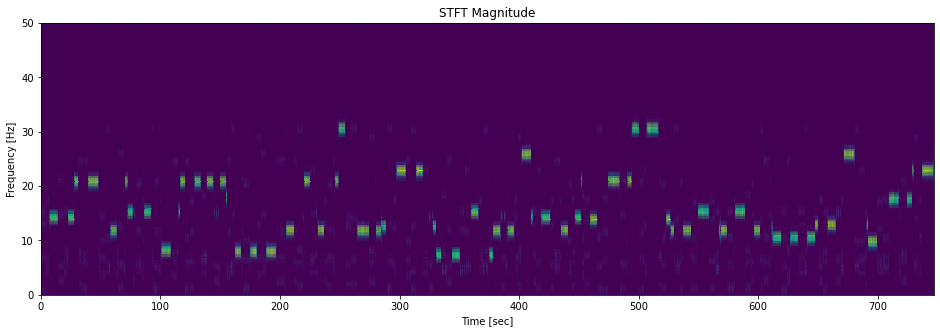

In [170]:

# Calculating the Fourier transform within the sliding window:----------------------------------
frequency_sampling = 1.0/settings.delta_t;
# Attention: 'settings.delta_t' and 'sliding_window_width' are selected according to the discritization
# frequency delta_f with in sliding window. The delta_f has to be equal to the 1 Hz.
delta_f = 1.0;
sliding_window_width = int(frequency_sampling/delta_f);


frequency_axis, time_axis, fourier_image_t = sp.stft(x=eeg_waves.signal,
                                                     fs=frequency_sampling,
                                                     nperseg=sliding_window_width,
                                                     detrend="constant",
                                                     noverlap=sliding_window_width-1)

power_spectral_density_t = np.abs(fourier_image_t)**2;
max_power_spectral_density = np.max(power_spectral_density_t);

print ("  --> Power spectral density {}".format(power_spectral_density_t.shape));
print ("  --> Frequency axis {}".format(frequency_axis.shape));
print ("  --> Time axis {}".format(time_axis.shape))
print ("  --> Power spectral density matrix {}".format(power_spectral_density_t));

plt.pcolormesh(time_axis, frequency_axis, power_spectral_density_t,
               vmin=0, vmax=max_power_spectral_density, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# documents: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html

In [6]:
#f, t, fourier_image_t_127 = sp.stft(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=128,detrend="constant",noverlap=127)
#power_spectral_density_t_127 = np.abs(fourier_image_t_127)**2;
#f, t, fourier_image_t_512 = sp.stft(x=eeg_waves.signal, fs=1.0/settings.delta_t, nperseg=512,detrend="constant",noverlap=511)
#power_spectral_density_t_512 = np.abs(fourier_image_t_512)**2;

#power_spectral_density_t = power_spectral_density_t_127*power_spectral_density_t_512


In [176]:
print ("  --> Temporal dependence of spectral density has the following shape={}".format(power_spectral_density_t.shape))

frequency_labels = [];

for i in range(0,frequency_axis.shape[0]):
    frequency_labels.append("f={}Hz".format(frequency_axis[i]));
    
print("  --> Made frequency_labels={}".format(frequency_labels));

  --> Temporal dependence of spectral density has the following shape=(51, 74690)
  --> Made frequency_labels=['f=0.0Hz', 'f=1.0Hz', 'f=2.0Hz', 'f=3.0Hz', 'f=4.0Hz', 'f=5.0Hz', 'f=6.0Hz', 'f=7.0Hz', 'f=8.0Hz', 'f=9.0Hz', 'f=10.0Hz', 'f=11.0Hz', 'f=12.0Hz', 'f=13.0Hz', 'f=14.0Hz', 'f=15.0Hz', 'f=16.0Hz', 'f=17.0Hz', 'f=18.0Hz', 'f=19.0Hz', 'f=20.0Hz', 'f=21.0Hz', 'f=22.0Hz', 'f=23.0Hz', 'f=24.0Hz', 'f=25.0Hz', 'f=26.0Hz', 'f=27.0Hz', 'f=28.0Hz', 'f=29.0Hz', 'f=30.0Hz', 'f=31.0Hz', 'f=32.0Hz', 'f=33.0Hz', 'f=34.0Hz', 'f=35.0Hz', 'f=36.0Hz', 'f=37.0Hz', 'f=38.0Hz', 'f=39.0Hz', 'f=40.0Hz', 'f=41.0Hz', 'f=42.0Hz', 'f=43.0Hz', 'f=44.0Hz', 'f=45.0Hz', 'f=46.0Hz', 'f=47.0Hz', 'f=48.0Hz', 'f=49.0Hz', 'f=50.0Hz']


In [189]:
# Making pandas data frame from transposed matrix of spectral dentsity
# and respective frequency labels:----------------------------------------------------

df = pd.DataFrame(data=power_spectral_density_t.T,columns=frequency_labels)

# Adding special column as the data frame target:-------------------------------------
df["target"]=pd.Series(eeg_waves.target_signal)

# We do not consider ZERO frequecies
df=df.drop(columns=["f=0.0Hz"])
df.info()
frequency_labels=frequency_labels[1:len(frequency_labels)]
print("  --> Made frequency_labels={}".format(frequency_labels));

# Nan controlling:--------------------------------------
count_nan_in_df = df.isnull().sum().sum()
print ('  --> Original count of NaN: ' + str(count_nan_in_df))

# Deleting nan:-----------------------------------------
if count_nan_in_df>0:
    df = df.drop(df[df["target"].isnull()].index);
    count_nan_in_df = df.isnull().sum().sum()
    print ('  --> Residual count of NaN: ' + str(count_nan_in_df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74690 entries, 0 to 74689
Data columns (total 51 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   f=1.0Hz   74690 non-null  float64
 1   f=2.0Hz   74690 non-null  float64
 2   f=3.0Hz   74690 non-null  float64
 3   f=4.0Hz   74690 non-null  float64
 4   f=5.0Hz   74690 non-null  float64
 5   f=6.0Hz   74690 non-null  float64
 6   f=7.0Hz   74690 non-null  float64
 7   f=8.0Hz   74690 non-null  float64
 8   f=9.0Hz   74690 non-null  float64
 9   f=10.0Hz  74690 non-null  float64
 10  f=11.0Hz  74690 non-null  float64
 11  f=12.0Hz  74690 non-null  float64
 12  f=13.0Hz  74690 non-null  float64
 13  f=14.0Hz  74690 non-null  float64
 14  f=15.0Hz  74690 non-null  float64
 15  f=16.0Hz  74690 non-null  float64
 16  f=17.0Hz  74690 non-null  float64
 17  f=18.0Hz  74690 non-null  float64
 18  f=19.0Hz  74690 non-null  float64
 19  f=20.0Hz  74690 non-null  float64
 20  f=21.0Hz  74690 non-null  fl

# Введение

На основе генератора мы получили data frame, состоящий из набора строк, каждая строка - это вектор. Координаты вектора это точки дискретизованного Фурье-спектра. По этим спектрам выделено 3 класса состояний при экспертной разметке. Набор векторов, уложенных в таблицу составляет данные в исследуемом data frame. Отдельной колонкой в data frame прописывается target. Эта колонка ставит в соответствие каждому вектору-строке его класс по экспертной разметке. Классов -три, поэтому и значения будут от 1 до 3 соответственно. Далее мы разобьем этот data frame на X и Y frame. В Х будут только вектора для классификации, как входные данные. По этим входным данным алгоритм классификации будет делать предположение о принадлежности объекта к определенному классу, выдавая его номер на выходе. В Y будут указания на правильные классы, по которым предполагается оценивать точность алгоритма классификации согласно экспертной разметке.

In [370]:
from sklearn.model_selection import train_test_split

# Создаем X ,Y для обучения и анализа:
X = pd.DataFrame(data=df,columns=frequency_labels);
Y = pd.DataFrame(data=df,columns=['target'])
X.info();
Y.info();

# Разделяем на тестовую и валидационную выборки:
# train---test----train-----test-----
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.25,shuffle=True)
print("X train shape={}".format(X_train.shape));
print("X test shape={}".format(X_test.shape));
print("Y train shape={}".format(Y_train.shape));
print("Y test shape={}".format(Y_test.shape));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74689 entries, 0 to 74688
Data columns (total 50 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   f=1.0Hz   74689 non-null  float64
 1   f=2.0Hz   74689 non-null  float64
 2   f=3.0Hz   74689 non-null  float64
 3   f=4.0Hz   74689 non-null  float64
 4   f=5.0Hz   74689 non-null  float64
 5   f=6.0Hz   74689 non-null  float64
 6   f=7.0Hz   74689 non-null  float64
 7   f=8.0Hz   74689 non-null  float64
 8   f=9.0Hz   74689 non-null  float64
 9   f=10.0Hz  74689 non-null  float64
 10  f=11.0Hz  74689 non-null  float64
 11  f=12.0Hz  74689 non-null  float64
 12  f=13.0Hz  74689 non-null  float64
 13  f=14.0Hz  74689 non-null  float64
 14  f=15.0Hz  74689 non-null  float64
 15  f=16.0Hz  74689 non-null  float64
 16  f=17.0Hz  74689 non-null  float64
 17  f=18.0Hz  74689 non-null  float64
 18  f=19.0Hz  74689 non-null  float64
 19  f=20.0Hz  74689 non-null  float64
 20  f=21.0Hz  74689 non-null  fl

In [371]:
# Lets observe the first 1000 vectors:
X.head(1000)

,f=1.0Hz,f=2.0Hz,f=3.0Hz,f=4.0Hz,f=5.0Hz,f=6.0Hz,f=7.0Hz,f=8.0Hz,f=9.0Hz,f=10.0Hz,...,f=41.0Hz,f=42.0Hz,f=43.0Hz,f=44.0Hz,f=45.0Hz,f=46.0Hz,f=47.0Hz,f=48.0Hz,f=49.0Hz,f=50.0Hz
0,0.087190,0.041686,0.007383,0.018881,0.054469,0.093520,0.071744,0.019605,0.001985,0.005292,...,0.001029,0.000446,0.002094,0.001894,0.001765,0.001337,0.000028,0.001273,0.001492,0.000236
1,0.087435,0.041571,0.006898,0.018632,0.055441,0.098220,0.075367,0.019793,0.001756,0.005332,...,0.001070,0.000426,0.002258,0.001903,0.001787,0.001474,0.000012,0.001415,0.001632,0.000181
2,0.089037,0.041327,0.006399,0.018334,0.056178,0.102795,0.078982,0.019892,0.001544,0.005350,...,0.001120,0.000409,0.002432,0.001902,0.001801,0.001625,0.000007,0.001573,0.001783,0.000129
3,0.090771,0.040954,0.005898,0.017979,0.056693,0.107185,0.082588,0.019901,0.001352,0.005340,...,0.001178,0.000397,0.002618,0.001893,0.001807,0.001789,0.000015,0.001748,0.001945,0.000083
4,0.088934,0.040461,0.005399,0.017569,0.056980,0.111361,0.086163,0.019831,0.001179,0.005303,...,0.001243,0.000393,0.002810,0.001879,0.001804,0.001969,0.000038,0.001943,0.002116,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.011255,0.009929,0.003640,0.008582,0.011652,0.001507,0.001465,0.000171,0.000374,0.001240,...,0.028350,0.026804,0.008416,0.013924,0.010669,0.001677,0.002067,0.001115,0.021607,0.044257
996,0.007751,0.010143,0.004065,0.008573,0.011837,0.001899,0.001408,0.000181,0.000351,0.001156,...,0.028728,0.025917,0.007410,0.012885,0.009995,0.001943,0.002018,0.000980,0.020726,0.043071
997,0.002614,0.010335,0.004501,0.008538,0.011981,0.002349,0.001373,0.000195,0.000328,0.001084,...,0.029051,0.024994,0.006449,0.011865,0.009342,0.002216,0.001982,0.000880,0.019787,0.041854
998,0.000471,0.010553,0.004929,0.008458,0.012112,0.002829,0.001372,0.000208,0.000304,0.001044,...,0.029297,0.024059,0.005545,0.010858,0.008716,0.002488,0.001960,0.000820,0.018787,0.040625


In [372]:
# Lets observe the first 1000 classifiers:
Y.head(1000)

,target
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
995,2.0
996,2.0
997,2.0
998,2.0


In [373]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
    

# The basic method for lauching and calculating accuracy metrics:----------------
def execute_model (x_train,y_train,model,x_test,y_test):
    
    # FIT means learning; 
    model.fit(x_train,y_train)
    
    # Predict means analyzing test data
    y_predict = model.predict(x_test)
    
    mse = mean_squared_error(y_test,y_predict)
    print("     > Mean squared error {}".format(mse))
    
    mae = mean_absolute_error(y_test,y_predict)
    print("     > Mean abs error {}".format(mae))
    
    # ATTENTION: Accuracy cannot be calculated for multiclass:
    try:
        accuracy = accuracy_score(y_test,y_predict)
        print ("     > Accuracy {}".format(accuracy))
    except:
        print("     > Accuracy was not calculated");
    
    try:
        confusion=confusion_matrix(y_test,y_predict)
        tp = confusion[1,1]
        tn = confusion[0,0]
        fp = confusion[0,1]
        fn = confusion[1,0]
        print ("     > TruePositive {} TrueNegative {} FalsePositive {} FalseNegative {}".format(tp,tn,fp,fn))
    except:
        print("     > Confusion was not calculated")
    
    r2s = r2_score(y_test,y_predict);
    print ("     > R2 = {}".format(r2s)); # 0 means bad , 1 means exceelent
    return y_predict;


# The basic function for executing scalers:--------------------------------------
def execute_scaling (x_train, scaler, x_test, make_data_frame):
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if make_data_frame:
        x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
        x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns);
    
    return (x_train_scaled, x_test_scaled)
    

# Линейная регрессия

Применим модель линейной регрессии для задачи классификации по 3 классам из X и Y соответственно

In [374]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression();
execute_model(X_train,Y_train,lin_reg,X_test,Y_test)


     > Mean squared error 0.02178892251817498
     > Mean abs error 0.09350232671544384
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9667940362759981


array([[0.924515  ],
       [3.06810115],
       [1.92101941],
       ...,
       [1.03013576],
       [1.15232575],
       [2.93301457]])

<b>Анализ коэффициентов линейной регрессии</b><br>
Рассмотрим коэффициенты полученной регрессии. Количественная оценка поможет определить необходимость масштабирования входных векторов.

In [375]:
lin_reg.intercept_ # free coefficient w0 from y=w0+w1x1+w2x2+..+wNxN

array([0.81988789])

In [376]:
lin_reg.coef_ # all coefficients from y=w0+w1x1+w2x2+..+wNxN except w0

array([[ 0.00735609, -0.32890964,  0.17592716, -0.33096335,  0.11962937,
        -0.22491972,  0.37474967,  0.35781046,  0.38030695,  0.32888851,
         0.39937732,  0.35425119,  0.35877955,  0.4606512 , -0.17242414,
         0.66794447, -0.09087668,  0.43503816, -0.15838475,  0.21748617,
         0.18228224,  0.21920422,  0.15955697,  0.31539851,  0.0365044 ,
         0.2203406 ,  0.29496655, -0.43341878,  0.32083594,  0.20311197,
         0.18438559,  0.25690779, -0.54265311,  0.85414404, -0.368503  ,
        -0.35937078, -0.03609688, -0.21559628, -0.77005337,  0.79626465,
        -0.75802489,  0.47609465,  0.40958945, -1.26195748,  0.18982138,
        -0.17672075, -0.18434243,  0.81739766, -1.2869796 , -0.19914658]])

Все коэффициенты модели линейной регрессии соответствуют соответствующим параметрам анализиуруемой выборки. Поэтому столбчатая
диаграмма покажет их величину 

Text(0, 0.5, 'property')

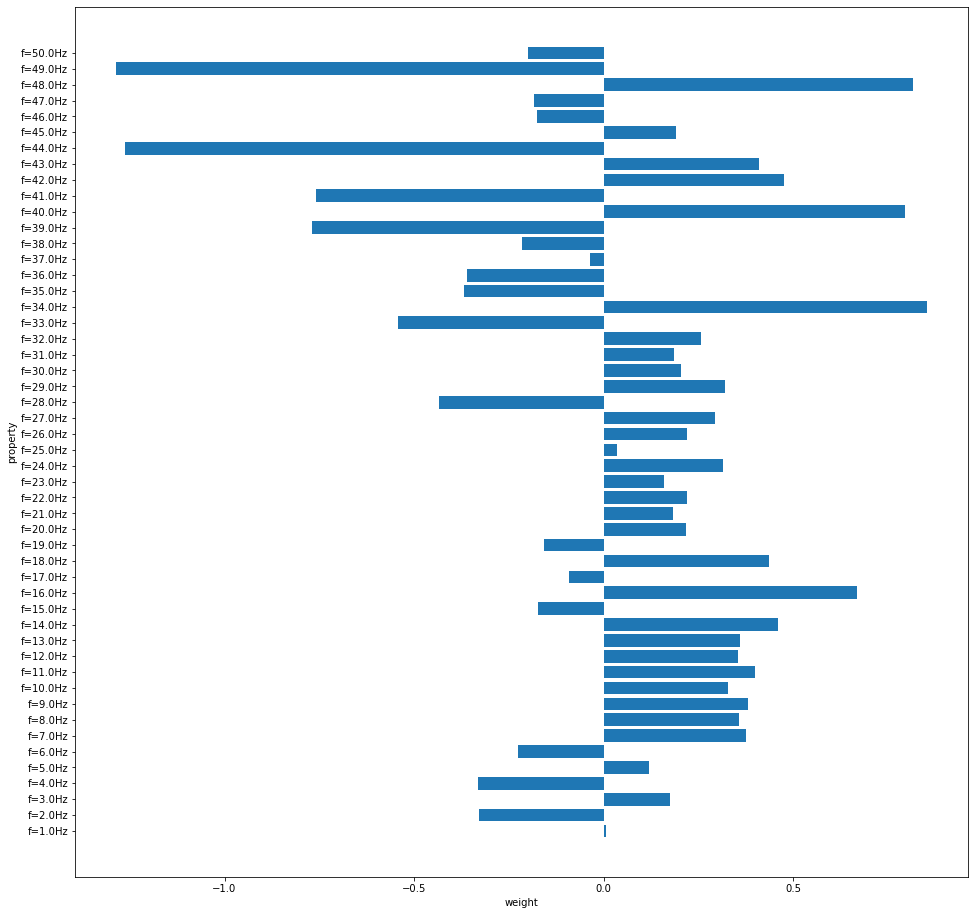

In [377]:

rcParams['figure.figsize'] = 16,16

plt.barh(X_train.columns,lin_reg.coef_.flatten())
plt.xlabel('weight')
plt.ylabel('property')

<b>Линейнай регрессия с масштабированием признаков</b>

In [378]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
#scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler();
scaler = MaxAbsScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,x_test=X_test,make_data_frame=True)

lin_reg = LinearRegression()
execute_model(X_train_scaler,Y_train,lin_reg,X_test_scaler,Y_test)


     > Mean squared error 0.021788922518174984
     > Mean abs error 0.09350232671544392
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9667940362759981


array([[0.924515  ],
       [3.06810115],
       [1.92101941],
       ...,
       [1.03013576],
       [1.15232575],
       [2.93301457]])

Text(0, 0.5, 'property')

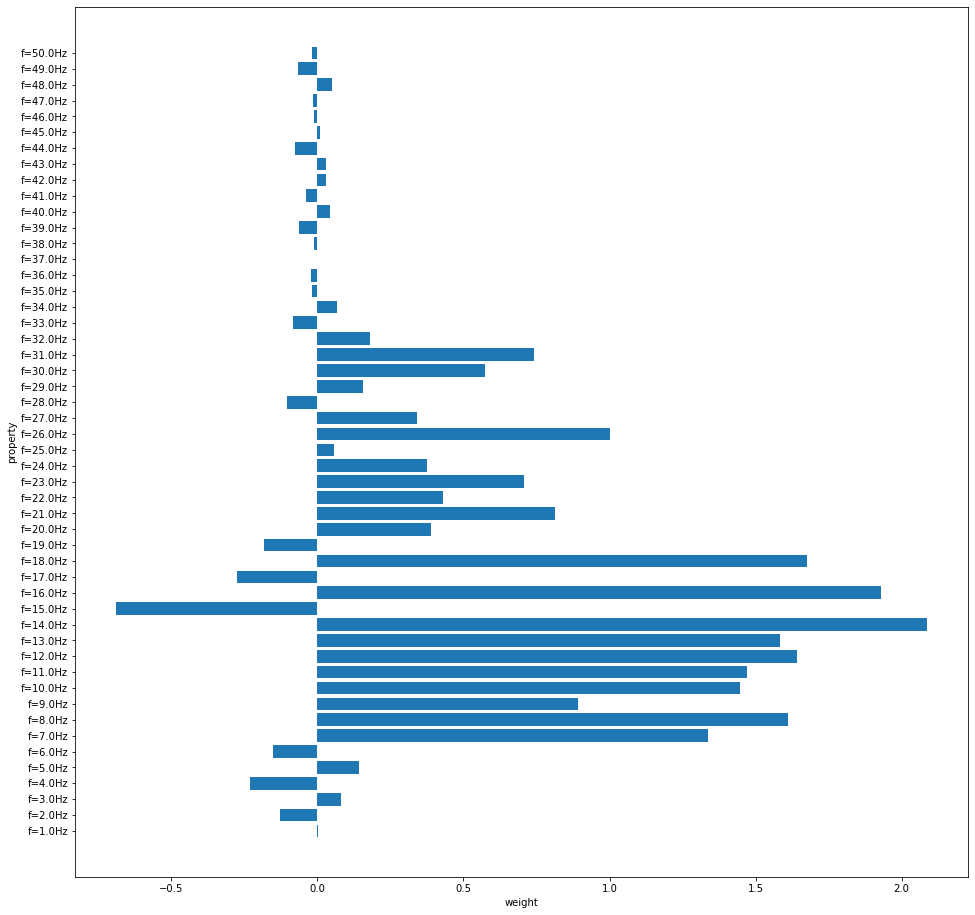

In [379]:
rcParams['figure.figsize'] = 16,16

plt.barh(X_train.columns,lin_reg.coef_.flatten())
plt.xlabel('weight')
plt.ylabel('property')

<b>Линейная регрессия с регуляризацией</b>

In [380]:
from sklearn.linear_model import Lasso

# Parameter ALPHA is responsible for regularisation
# The higher alpha - the stronger regularization and the lower overlearning
print ('  --> Lasso 1 regularization: ')
execute_model(X_train,Y_train,Lasso(alpha=0.01),X_test,Y_test)

print ('  --> Lasso 2 regularization: ')
execute_model(X_train,Y_train,Lasso(alpha=0.001),X_test,Y_test)

print ('  --> Lasso 3 regularization: ')
execute_model(X_train,Y_train,Lasso(alpha=0.0001),X_test,Y_test)

print ('  --> Lasso 4 regularization: ')
execute_model(X_train,Y_train,Lasso(alpha=0.00001),X_test,Y_test)


  --> Lasso 1 regularization: 
     > Mean squared error 0.032869498428236006
     > Mean abs error 0.12336922255212039
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9499074187113332
  --> Lasso 2 regularization: 
     > Mean squared error 0.023373606191953306
     > Mean abs error 0.09538634902322256
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9643790041172666
  --> Lasso 3 regularization: 
     > Mean squared error 0.021963417541490674
     > Mean abs error 0.09319602760310335
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9665281086969998
  --> Lasso 4 regularization: 
     > Mean squared error 0.02178346613481674
     > Mean abs error 0.09313529503755863
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9668023517155389


array([0.91669087, 3.05630523, 1.92788218, ..., 1.02573054, 1.15474735,
       2.92954312])

In [381]:
from sklearn.linear_model import Ridge

print ('  --> Ridge 1 regularization: ')
execute_model(X_train,Y_train,Ridge(alpha=0.01),X_test,Y_test)

print ('  --> Ridge 2 regularization: ')
execute_model(X_train,Y_train,Ridge(alpha=0.001),X_test,Y_test)

print ('  --> Ridge 3 regularization: ')
execute_model(X_train,Y_train,Ridge(alpha=0.0001),X_test,Y_test)

print ('  --> Ridge 4 regularization: ')
execute_model(X_train,Y_train,Ridge(alpha=0.00001),X_test,Y_test)

  --> Ridge 1 regularization: 
     > Mean squared error 0.02178659417058659
     > Mean abs error 0.09347851201030352
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.966797584639874
  --> Ridge 2 regularization: 
     > Mean squared error 0.021788670025702297
     > Mean abs error 0.09349982381044136
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.966794421070422
  --> Ridge 3 regularization: 
     > Mean squared error 0.021788897058011028
     > Mean abs error 0.09350207519735215
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9667940750768741
  --> Ridge 4 regularization: 
     > Mean squared error 0.021788919970034033
     > Mean abs error 0.0935023015555341
     > Accuracy was not calculated
     > Confusion was not calculated
     > R2 = 0.9667940401593235


array([[0.9245146 ],
       [3.06810052],
       [1.92101944],
       ...,
       [1.03013552],
       [1.1523256 ],
       [2.93301442]])

Масштабирование признаков не дало ощутимого прироста для решения этой задачи. Регуляризация подтвердила исходные цифры по точности. Дополнительных преимуществ от ее внедрения не обнаружено.

# Метод опорных векторов

Применим метод опорных векторов для задачи классификации по 3 классам из X и Y соответственно

In [386]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Support vector machine is sensible for non scaled data. That is why
# we have to use scaler
scaler = MinMaxScaler()
#scaler = RobustScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=True);

#X_train_scaler.describe()

In [387]:
from sklearn.svm import SVC

c_param_values = np.linspace(start=0.1,stop=2.1, num=20)
for c_param in c_param_values:
    print("  --> Executing SVC with c={}".format(c_param))
    execute_model(X_train_scaler,Y_train["target"],SVC(C=c_param),X_test_scaler,Y_test["target"])


  --> Executing SVC with c=0.1
     > Mean squared error 0.009354303157969902
     > Mean abs error 0.0057482549940196725
     > Accuracy 0.9960547690879554
     > TruePositive 14557 TrueNegative 28688 FalsePositive 42 FalseNegative 78
     > R2 = 0.9857441940477889
  --> Executing SVC with c=0.20526315789473684
     > Mean squared error 0.007408465287323491
     > Mean abs error 0.004552189513897567
     > Accuracy 0.9968759483728153
     > TruePositive 14572 TrueNegative 28690 FalsePositive 32 FalseNegative 63
     > R2 = 0.9887096193317412
  --> Executing SVC with c=0.31052631578947365
     > Mean squared error 0.006997875644893514
     > Mean abs error 0.004284413660138886
     > Accuracy 0.9970723173322384
     > TruePositive 14575 TrueNegative 28692 FalsePositive 28 FalseNegative 60
     > R2 = 0.9893353512723917
  --> Executing SVC with c=0.4157894736842105
     > Mean squared error 0.006801506685470482
     > Mean abs error 0.004195155042219326
     > Accuracy 0.997108020779406

# Алгоритм K- ближайших соседей (KNN)

Применим метод K- ближайших соседей для задачи классификации по 3 классам из X и Y соответственно

In [388]:

scaler = MinMaxScaler()
#scaler = RobustScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=True);
#X_train_scaler.describe()

In [327]:
from sklearn.neighbors import KNeighborsClassifier

for n_neighbours in range(1,n_spectral_features):
    print("  --> Executing KNN n_neighbours={}".format(n_neighbours))
    execute_model(X_train_scaler,Y_train["target"],
                  KNeighborsClassifier(n_neighbors=n_neighbours),X_test_scaler,Y_test["target"])


  --> Executing KNN n_neighbours=1
     > Mean squared error 0.011246485473289597
     > Mean abs error 0.006426563127594056
     > Accuracy 0.9959833980452537
     > TruePositive 17496 TrueNegative 34375 FalsePositive 62 FalseNegative 46
     > R2 = 0.9828675583111957
  --> Executing KNN n_neighbours=2
     > Mean squared error 0.014251498787581262
     > Mean abs error 0.008390235194358905
     > Accuracy 0.9945403966022522
     > TruePositive 17410 TrueNegative 34442 FalsePositive 32 FalseNegative 132
     > R2 = 0.9782898424102189
  --> Executing KNN n_neighbours=3
     > Mean squared error 0.012882878862260305
     > Mean abs error 0.007586914803409649
     > Accuracy 0.9950610672260157
     > TruePositive 17453 TrueNegative 34359 FalsePositive 65 FalseNegative 86
     > R2 = 0.9803747427215549
  --> Executing KNN n_neighbours=4
     > Mean squared error 0.013091147111765669
     > Mean abs error 0.007884440874131596
     > Accuracy 0.9947189122446854
     > TruePositive 17409 Tru

# Деревья в решении задачи классификации

In [329]:
from sklearn.tree import DecisionTreeClassifier

for depth in range(1,n_spectral_features,1):
    print("  --> Executing DecisionTree depth={}".format(depth));
    execute_model(X_train,Y_train,
              DecisionTreeClassifier(max_depth=depth),X_test,Y_test)


  --> Executing DecisionTree depth=1
     > Mean squared error 0.3637256214575802
     > Mean abs error 0.3004715788220943
     > Accuracy 0.7311554424956487
     > TruePositive 16888 TrueNegative 32261 FalsePositive 2238 FalseNegative 654
     > R2 = 0.44591508030255944
  --> Executing DecisionTree depth=2
     > Mean squared error 0.18036030407164427
     > Mean abs error 0.13480906264411419
     > Accuracy 0.8879665580696509
     > TruePositive 16825 TrueNegative 32207 FalsePositive 1467 FalseNegative 654
     > R2 = 0.725246398101768
  --> Executing DecisionTree depth=3
     > Mean squared error 0.09563975543356987
     > Mean abs error 0.06823760432007854
     > Accuracy 0.9454634712366671
     > TruePositive 16813 TrueNegative 32738 FalsePositive 1173 FalseNegative 658
     > R2 = 0.854306259765446
  --> Executing DecisionTree depth=4
     > Mean squared error 0.05618779845583969
     > Mean abs error 0.040716442778298445
     > Accuracy 0.9670192350604722
     > TruePositive 169

     > Mean squared error 0.01695898603115098
     > Mean abs error 0.010175391618690587
     > Accuracy 0.9932164055875397
     > TruePositive 17436 TrueNegative 34302 FalsePositive 98 FalseNegative 100
     > R2 = 0.9741653657073586
  --> Executing DecisionTree depth=32
     > Mean squared error 0.016825099299326105
     > Mean abs error 0.010101010101010102
     > Accuracy 0.993261034498148
     > TruePositive 17421 TrueNegative 34317 FalsePositive 88 FalseNegative 116
     > R2 = 0.974369323346511
  --> Executing DecisionTree depth=33
     > Mean squared error 0.017048243852367563
     > Mean abs error 0.010353907261123755
     > Accuracy 0.9929932610344981
     > TruePositive 17427 TrueNegative 34312 FalsePositive 113 FalseNegative 107
     > R2 = 0.9740293939479236
  --> Executing DecisionTree depth=34
     > Mean squared error 0.01689948081700659
     > Mean abs error 0.01038365986819595
     > Accuracy 0.9928742506062094
     > TruePositive 17432 TrueNegative 34307 FalsePositiv

<b>Ансамбли деревьев</b>

In [330]:
# Random forest . It's used an assembly of trees. The grouped trees are named as bagging.
# The quorum of groups are determined the class of the classified object
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = [{'n_estimators':[3,6,9],'max_features':np.arange(5,10),'max_depth':np.arange(5,15)}]

# n_estimators - is the number of trees 
# max_features - Max parameters per tree
# max_depth - max depth of the each tree
# grid search with cross validation. cv = 5. The first fourth groups (FOLDS) of the train set is used for FIT the last is used for vaidation
clf = GridSearchCV(estimator=RandomForestClassifier(random_state=100),param_grid=parameters,scoring='accuracy',cv=5)
clf.fit(X_train,Y_train["target"])

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid=[{'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                          'max_features': array([5, 6, 7, 8, 9]),
                          'n_estimators': [3, 6, 9]}],
             scoring='accuracy')

In [331]:

means=clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean,std,params in zip(means,stds,clf.cv_results_['params']):
    print("%0.5f (%0.05f) =>%r"%(mean,std*2,params))
    
    

0.95246 (0.04636) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 3}
0.97550 (0.00346) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 6}
0.98674 (0.00392) =>{'max_depth': 5, 'max_features': 5, 'n_estimators': 9}
0.97550 (0.01982) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 3}
0.97737 (0.01548) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 6}
0.98420 (0.00706) =>{'max_depth': 5, 'max_features': 6, 'n_estimators': 9}
0.94684 (0.02038) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 3}
0.96893 (0.00972) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 6}
0.97215 (0.00702) =>{'max_depth': 5, 'max_features': 7, 'n_estimators': 9}
0.98112 (0.00741) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 3}
0.98433 (0.00540) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 6}
0.98527 (0.00791) =>{'max_depth': 5, 'max_features': 8, 'n_estimators': 9}
0.96170 (0.00860) =>{'max_depth': 5, 'max_features': 9, 'n_estimators': 3}
0.98500 (0.01337) =>{'max

In [332]:
# selected the best params from the grid search:r
random_forest_classifier = RandomForestClassifier(max_depth=9,max_features=7,n_estimators=9)
execute_model(X_train,Y_train["target"],random_forest_classifier,X_test,Y_test["target"])


     > Mean squared error 0.012734115826899333
     > Mean abs error 0.00791419348120379
     > Accuracy 0.9944957676916439
     > TruePositive 17406 TrueNegative 34368 FalsePositive 59 FalseNegative 136
     > R2 = 0.9806013623206131


array([1., 1., 1., ..., 3., 1., 2.])

# Конвеерный алгоритм на основе АГК и деревьев с разной глубиной

In [369]:
# document source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

from sklearn.decomposition import PCA


# Scaling:-------------------------------------------------------------
scaler = MinMaxScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=False);



# Applying PCA:-------------------------------------------------------
pca = PCA (n_components=int(n_spectral_features/2));

X_train_pca=pca.fit_transform(X_train_scaler);
X_test_pca = pca.transform(X_test_scaler)

print("PCA explained variance {}".format(pca.explained_variance_ratio_))
print("X test PCA shape = {}".format(X_test_pca.shape))


# Executing decision tree with PCA:----------------------------------
for depth in range(1,n_spectral_features,1):
    print("  --> Executing DecisionTree depth={}".format(depth));
    execute_model(X_train_pca,Y_train,
              DecisionTreeClassifier(max_depth=depth),X_test_pca,Y_test)


PCA explained variance [0.11709373 0.10259248 0.08867841 0.06380746 0.05447368 0.05179374
 0.04739467 0.04182367 0.03429524 0.03208387 0.03110399 0.030473
 0.02789485]
X test PCA shape = (67221, 13)
  --> Executing DecisionTree depth=1
     > Mean squared error 0.39456419868791004
     > Mean abs error 0.30411627318843815
     > Accuracy 0.7411076895612978
     > TruePositive 17333 TrueNegative 32485 FalsePositive 2014 FalseNegative 209
     > R2 = 0.3989368374177825
  --> Executing DecisionTree depth=2
     > Mean squared error 0.11909968610999538
     > Mean abs error 0.10181342140105026
     > Accuracy 0.9068297109534222
     > TruePositive 17331 TrueNegative 32332 FalsePositive 2010 FalseNegative 209
     > R2 = 0.8185683489939587
  --> Executing DecisionTree depth=3
     > Mean squared error 0.06826735692715075
     > Mean abs error 0.0628523824400113
     > Accuracy 0.9398551048035584
     > TruePositive 17331 TrueNegative 32366 FalsePositive 2010 FalseNegative 179
     > R2 = 0.

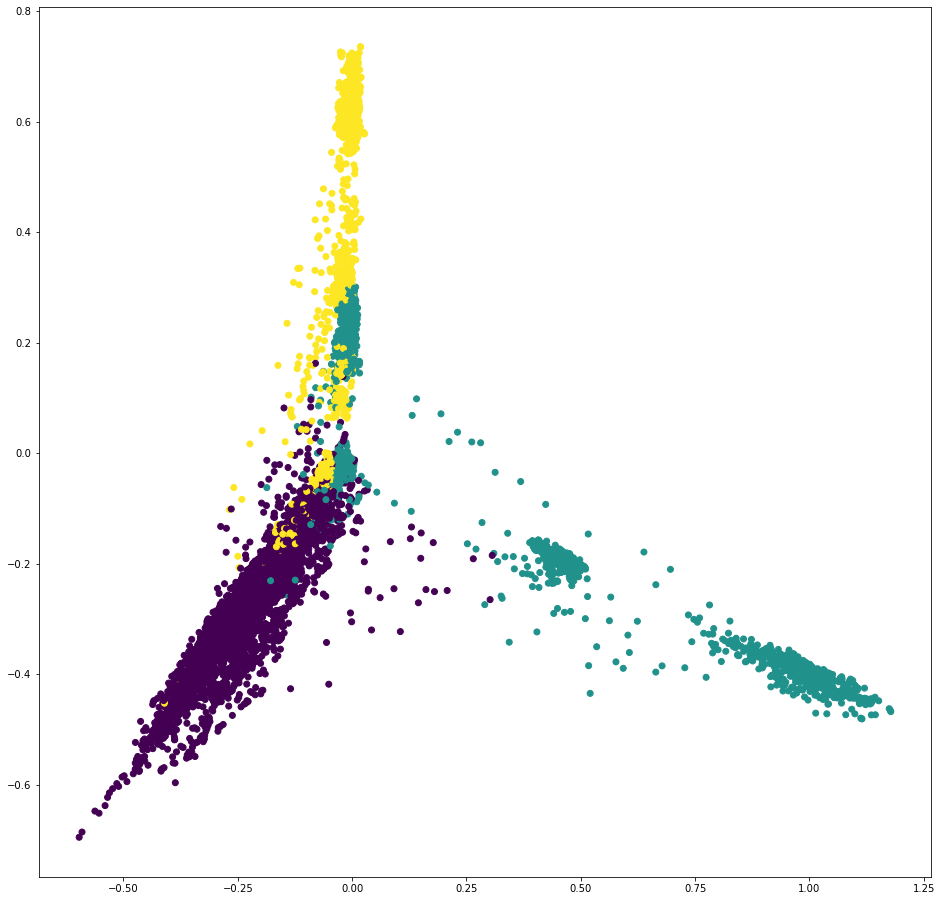

In [356]:
from sklearn.decomposition import PCA


# Reseaching PCA transform output:-----------------------------
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)

pca = PCA (n_components=33)
cluster = pca.fit_transform(X_train_scaler)
cluster2 = X_train_scaler @ pca.components_.T

i1 = 0;
i2 = 1;

x=cluster[0:cluster.shape[0],i1:i1+1];
y=cluster[0:cluster.shape[0],i2:i2+1];
x1=cluster2[0:cluster2.shape[0],i1:i1+1];
y1=cluster2[0:cluster2.shape[0],i2:i2+1];

#plt.scatter(x,y,c=Y_train["target"]);
plt.scatter(x1,y1,c=Y_train["target"]);



# Метод стохастического обобщения соседей

In [339]:
from sklearn.manifold import TSNE

# document source: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# scaling:----------------------------------------------------------------
scaler=StandardScaler()

X_train_scaler,X_test_scaler = execute_scaling(x_train=X_train,scaler=scaler,
                                               x_test=X_test,make_data_frame=True);


# learning rate influences on cluster density:---------------------------
tsne = TSNE(n_components=7,
            #learning_rate=150,
            #random_state=100,
            method='exact'
           )
X_train_tsne = tsne.fit_transform(X_train_scaler)



C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

ValueError: 'c' argument has 7468 elements, which is inconsistent with 'x' and 'y' with size 1493.

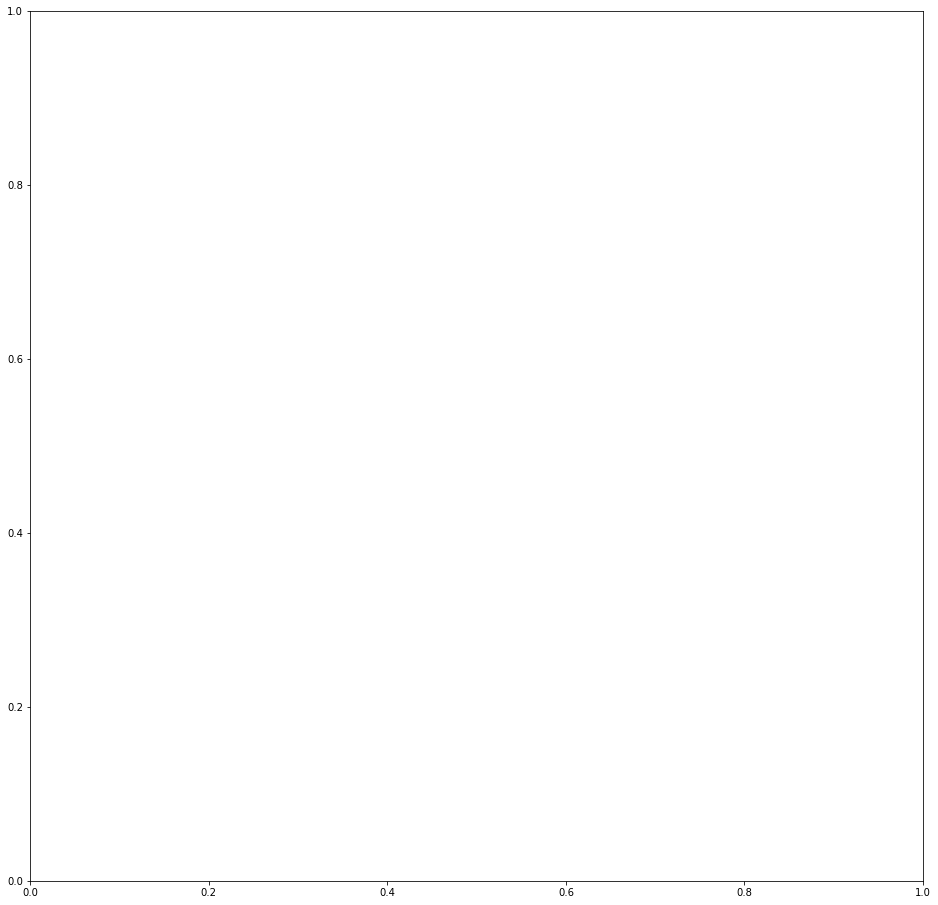

In [337]:
plt.scatter(X_train_tsne[:,0],X_train_tsne[:,1],c=Y_train["target"])

# Конвеерный алгоритм: Масштабирование + сжатие + кластеризация + классификация

Рассматривается комбинированный алгоритм, который опционально включает:<br>
1) масштабирование<br>
2) сжатие на основе АГК<br>
3) кластеризация пространства признаков на основе k-среднего<br>
4) построение классификации<br>
    
Количество кластеров и классов на стадии 3 и 4 мы ставим 3, потому что исходная задача имеет объекты трех классов.
Количество компонент сжатия мы устанавливаем на уровне чуть превышающеми количество гармоник в Фурье-спектре (см. выше).


In [112]:

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering.fit
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans.fit_transform
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.fit
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans

enable_scaler=False

enable_pca=True
n_components_pca = 17

enable_bis_kmeans=False
enable_kmeans=False
n_clusters_kmeans = 3

n_neigbours_knn = 3
X_train_exp=X_train;
X_test_exp=X_test;

if enable_scaler:
    print("  --> Executing min/max scaler")
    scaler = MinMaxScaler()
    X_train_exp = scaler.fit_transform(X_train_exp)
    X_test_exp = scaler.transform(X_test_exp)

if enable_pca:
    print("  --> PCA: n_components={}".format(n_components_pca))
    pca = PCA (n_components=n_components_pca)
    X_train_exp = pca.fit_transform(X_train_exp)
    X_test_exp = pca.transform(X_test_exp)
    
if enable_bis_kmeans:
    print("  --> Bisecting K means: n_clusters={}".format(n_clusters_kmeans))
    kMeans = BisectingKMeans(n_clusters=n_clusters_kmeans)
    X_train_exp = kMeans.fit_transform(X_train_exp)
    X_test_exp = kMeans.transform(X_test_exp);
    
if enable_kmeans:
    print("  --> K means: n_clusters={}".format(n_clusters_kmeans))
    kMeans = KMeans(n_clusters=n_clusters_kmeans)
    X_train_exp = kMeans.fit_transform(X_train_exp)
    X_test_exp = kMeans.transform(X_test_exp);

print("  --> KNN n_neigbours={}".format(n_neigbours_knn))
knn = KNeighborsClassifier(n_neighbors=n_neigbours_knn);
execute_model(X_train_exp,Y_train["target"],knn,X_test_exp,Y_test["target"])



  --> PCA: n_components=17
  --> KNN n_neigbours=3
Mean squared error 0.001688048615800135
Mean abs error 0.001012829169480081
R2 = 0.9971837115714972


array([1., 1., 3., ..., 1., 2., 1.])